# Koopman Seq2Seq model

[work in progress]

Here I develop a new ML architecture, combining Koopman kernel methods with a seq2seq architecture.

In [2]:
import os
import random
import time

import numpy as np
import torch
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from absl import app, flags

from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

from kkseq.koopkernel_sequencer import RBFKernel, NystroemKoopKernelSequencer

from klearn_tcyclone.data_utils import (
    standardized_context_dataset_from_TCTracks,
)

from matplotlib import pyplot as plt
from klearn_tcyclone.KNF.modules.models import Koopman
import torch


from klearn_tcyclone.koopkernel_sequencer_utils import train_KKSeq2Seq
from klearn_tcyclone.koopkernel_sequencer_utils import plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq
from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D
import logging

## Import data

Set some specific parameters and load default values for all other parameters.

In [3]:
flag_params = {
    # "seed": 42,
    "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 20,
    "train_output_length": 1,
    "test_output_length": 1,
    "input_length": 13,
    "context_length": 14,
}
flag_params = extend_by_default_flag_values(flag_params)

assert flag_params["context_length"] == flag_params["input_length"] + flag_params["train_output_length"]

In [4]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

# feature_list = [
#     "lon",
#     "lat",
#     "max_sustained_wind",
#     "radius_max_wind",
#     "radius_oci",
#     "central_pressure",
#     "environmental_pressure",
# ]

# these are not contained as flags
# encoder_hidden_dim = flag_params["hidden_dim"]
# decoder_hidden_dim = flag_params["hidden_dim"]
# encoder_num_layers = flag_params["num_layers"]
# decoder_num_layers = flag_params["num_layers"]

output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()

Device cuda


In [5]:
time_lag = 1
scaler = LinearScaler()
basin = "NA"

In [6]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official",
    year_range=flag_params["year_range"],
    basin=basin,
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

2025-03-21 20:31:24,822 - climada.hazard.tc_tracks - WARNING - 49 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


In [7]:
len(tc_tracks_train), tc_tracks_train[5]

(73,
 <xarray.Dataset> Size: 8kB
 Dimensions:                 (time: 134)
 Coordinates:
   * time                    (time) datetime64[ns] 1kB 1986-08-13T12:00:00 ......
     lat                     (time) float32 536B 30.1 30.45 30.8 ... 56.2 56.2
     lon                     (time) float32 536B -84.0 -84.0 -84.0 ... 7.0 8.0
 Data variables:
     radius_max_wind         (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     radius_oci              (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     max_sustained_wind      (time) float32 536B 10.0 10.0 10.0 ... 15.0 15.0
     central_pressure        (time) float32 536B 1.009e+03 1.01e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1kB 1.01e+03 1.01e+03 ... 1.01e+03
     time_step               (time) float64 1kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
     basin                   (time) <U2 1kB 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     orig_event

The idea is to feed the tensor_context_dataset into the model. Because for the kernels I need the lookback window and the shifted version of this.

In [8]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
)

In [9]:
tensor_context_train_standardized.shape

(3301, 14, 5)

In [10]:
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

In [11]:
#TODO Check why we have nan values!

### Single step model

In [12]:
# flag_params["koopman_kernel_num_centers"] = 200
flag_params["koopman_kernel_num_centers"] = 1000

In [13]:
# rbf = RBFKernel(length_scale=1E-1)

# #TODO some parameters don't play a role in model definition -> remove them
# koopkernelmodel = NystroemKoopKernelSequencer(
#     kernel=rbf,
#     input_dim = num_feats,
#     input_length = 13,
#     output_length = 1,
#     output_dim = 1,
#     num_steps = 1,
#     num_nys_centers = flag_params["koopman_kernel_num_centers"],
#     rng_seed = 42,
#     # context_mode="last_context"
#     # context_mode="no_context"
#     context_mode="full_context"
# )

# koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

#### Compare context modes

In [22]:
# Logging and define save paths
# current_file_dir_path = os.path.dirname(os.path.abspath(__file__))
current_file_dir_path = os.getcwd()
results_dir = os.path.join(
    current_file_dir_path,
    "training_results",
    "{}_yrange{}_basin{}".format(
        flag_params["dataset"],
        "".join(map(str, flag_params["year_range"])),
        flag_params["basin"],
    ),
    flag_params["model"],
)
logs_dir = os.path.join(
    current_file_dir_path,
    "logs",
    # flag_params["dataset"],
    "{}_yrange{}".format(
        flag_params["dataset"],
        "".join(map(str, flag_params["year_range"])),
    ),
)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
# logging.basicConfig(
#     filename=os.path.join(logs_dir, flag_params["model"] + "_testrun.log"),
#     encoding="utf-8",
#     filemode="a",
#     format="{asctime} - {name} - {filename}:{lineno} - {levelname} - {message}",
#     style="{",
#     datefmt="%Y-%m-%d %H:%M:%S",
#     force=True,
# )
# logger = logging.getLogger(flag_params["model"] + "_logger")
# logger.info(flag_params)





log_file_name = os.path.join(logs_dir, flag_params["model"] + ".log")

logFormatter = logging.Formatter(
    "%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    # style="{",
    # datefmt="%Y-%m-%d %H:%M:%S",
)
fileHandler = logging.FileHandler(log_file_name)
fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

In [23]:
model_name=flag_params["model"] + "_testrun"
results_file_name = os.path.join(results_dir, model_name)

eval_metric = RMSE_TCTracks
scaler = LinearScaler()

In [24]:
flag_params["koopman_kernel_num_centers"]

1000

In [25]:
flag_params

{'year_range': [1980, 1988],
 'num_epochs': 20,
 'train_output_length': 1,
 'test_output_length': 1,
 'input_length': 13,
 'context_length': 14,
 'seed': 123,
 'model': 'KNF',
 'dataset': 'TCTracks',
 'basin': 'EP',
 'time_step_h': 1.0,
 'global_local_combination': 'additive',
 'learning_rate': 0.001,
 'decay_rate': 0.9,
 'batch_size': 32,
 'min_epochs': 10,
 'data_dir': 'data_prep/M4/',
 'regularize_rank': False,
 'use_revin': True,
 'use_instancenorm': False,
 'add_global_operator': True,
 'add_control': True,
 'data_freq': 'None',
 'dropout_rate': 0.0,
 'latent_dim': 32,
 'num_steps': 5,
 'control_hidden_dim': 64,
 'num_layers': 4,
 'control_num_layers': 3,
 'jumps': 5,
 'input_dim': 7,
 'hidden_dim': 128,
 'num_heads': 1,
 'transformer_dim': 64,
 'transformer_num_layers': 3,
 'num_sins': -1,
 'num_poly': -1,
 'num_exp': -1,
 'time_lag': 1,
 'tikhonov_reg': 1e-08,
 'koopman_kernel_rank': 25,
 'koopman_kernel_reduced_rank': True,
 'koopman_kernel_num_centers': 1000,
 'koopman_kernel_

In [26]:
# flag_params["seed"] = 42

In [28]:
results_file_name

'c:\\Users\\ecjbr\\projects\\koopman_learning_tropical_cyclone\\examples\\training_results\\TCTracks_yrange19801988_basinEP\\KNF\\KNF_testrun'

In [30]:
rbf = RBFKernel(length_scale=1E-1)

context_modes = [
    # "no_context",
    "full_context",
    # "last_context",
]
models = {}
train_losses = {}
train_losses2 = {}
for cm in context_modes:


    #TODO some parameters don't play a role in model definition -> remove them
    koopkernelmodel = NystroemKoopKernelSequencer(
        kernel=rbf,
        input_dim = num_feats,
        input_length = flag_params["input_length"],
        output_length = flag_params["train_output_length"],
        output_dim = 1,
        num_steps = 1,
        num_nys_centers = flag_params["koopman_kernel_num_centers"],
        rng_seed = 42,
        context_mode=cm,
    )

    koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

    m, tl = train_KKSeq2Seq(
        model=koopkernelmodel,
        eval_metric=eval_metric,
        tc_tracks=tc_tracks,
        num_epochs=flag_params["num_epochs"],
        batch_size=flag_params["batch_size"],
        feature_list=feature_list,
        scaler=scaler,
        basin=basin,
        log_file_handler=fileHandler,
        results_dir=results_dir,
        model_name=model_name,
        flag_params=flag_params,
        results_file_name=results_file_name,
        split_valid_set = False,
    )

    models[cm] = m
    train_losses[cm] = tl


eval comparison 0.2594279168121067 1000000.0
eval comparison 0.36712129229344614 0.2594279168121067
eval comparison 0.29142297167523346 0.2594279168121067
eval comparison 0.30064184965182916 0.2594279168121067
eval comparison 0.30151297997769805 0.2594279168121067
eval comparison 0.27412968456639925 0.2594279168121067
eval comparison 0.263370110764846 0.2594279168121067
eval comparison 0.25789674643162347 0.2594279168121067
eval comparison 0.2582335997688312 0.25789674643162347
eval comparison 0.26000071406839503 0.25789674643162347
eval comparison 0.25946472153682937 0.25789674643162347
eval comparison 0.2584402711859822 0.25789674643162347
eval comparison 0.2560505998708548 0.25789674643162347
eval comparison 0.2534152574706526 0.2560505998708548
eval comparison 0.2514892140403171 0.2534152574706526
eval comparison 0.25050425246186725 0.2514892140403171
eval comparison 0.250328652602482 0.25050425246186725
eval comparison 0.25048590448899005 0.250328652602482
eval comparison 0.250702

In [32]:
train_losses

{'full_context': [np.float64(0.3806845851955537),
  np.float64(0.283151856613443),
  np.float64(0.23134851961312022),
  np.float64(0.19958685404042034),
  np.float64(0.1900725726177412),
  np.float64(0.1680045304545818),
  np.float64(0.13651747695905184),
  np.float64(0.11589350019939101),
  np.float64(0.09445358483804843),
  np.float64(0.07873382206563331),
  np.float64(0.07266343591700444),
  np.float64(0.06828342275238655),
  np.float64(0.06460144984314407),
  np.float64(0.06116634236866483),
  np.float64(0.058412677871027045),
  np.float64(0.05594148459768164),
  np.float64(0.05369704757976959),
  np.float64(0.052005067894001326),
  np.float64(0.05060448336497658),
  np.float64(0.049459204151681514)]}

In [33]:
np.array(train_losses["full_context"])**2

array([0.14492075, 0.08017497, 0.05352214, 0.03983491, 0.03612758,
       0.02822552, 0.01863702, 0.0134313 , 0.00892148, 0.00619901,
       0.00527997, 0.00466263, 0.00417335, 0.00374132, 0.00341204,
       0.00312945, 0.00288337, 0.00270453, 0.00256081, 0.00244621])

In [34]:
train_losses2

{}

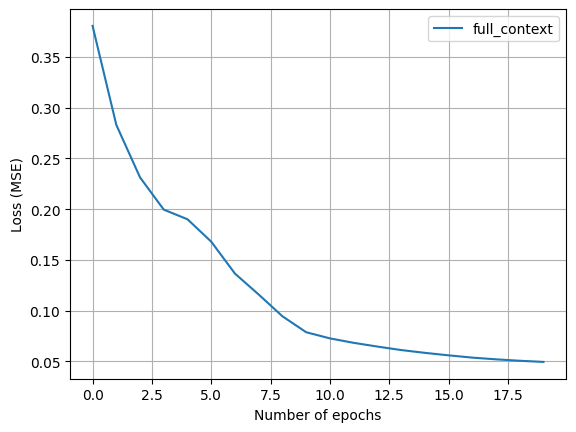

In [37]:
fig, ax = plt.subplots()

for idx, cm in enumerate(context_modes):
    ax.plot(range(flag_params["num_epochs"]), train_losses[cm], color = f"C{idx}", label = cm)
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

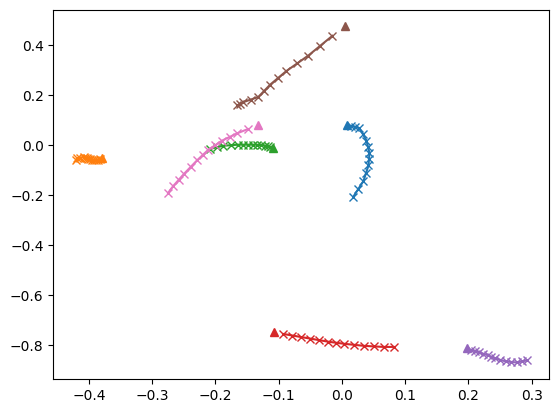

In [38]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])
torch.Size([3, 5])


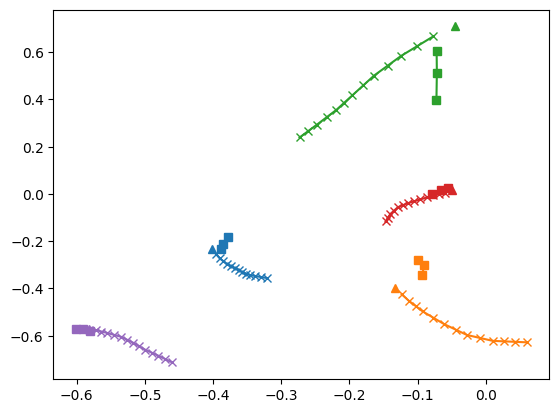

In [39]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=models["full_context"],
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

### Multi step model

In [80]:
flag_params["input_length"] = 13
flag_params["train_output_length"] = 5
flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]
flag_params["num_epochs"] = 50
# flag_params["koopman_kernel_num_centers"] = 50
flag_params["koopman_kernel_num_centers"] = 1000

In [81]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

intput_length and output_length are not None.


In [82]:
tensor_context_train_standardized.shape

(3015, 18, 5)

In [ ]:
# rbf = RBFKernel(length_scale=1E-1)

# #TODO some parameters don't play a role in model definition -> remove them
# koopkernelmodel = NystroemKoopKernelSequencer(
#     kernel=rbf,
#     input_dim = num_feats,
#     input_length = flag_params["input_length"],
#     output_length = flag_params["train_output_length"],
#     output_dim = 1,
#     num_steps = 1,
#     num_nys_centers = flag_params["koopman_kernel_num_centers"],
#     rng_seed = 42,
#     # context_mode="last_context"
#     context_mode="no_context"
#     # context_mode="full_context"
# )

# koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

#### Compare context modes

In [85]:
flag_params["train_output_length"]

5

In [ ]:
# context_modes = [
#     "no_context",
#     "full_context",
#     "last_context",
# ]
# models = {}
# train_losses = {}
# for cm in context_modes:
#     m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
#     models[cm] = m
#     train_losses[cm] = tl


rbf = RBFKernel(length_scale=1E-1)

context_mode = "last_context"
# context_mode = "full_context"
# context_mode = "no_context"

koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_dim = num_feats,
    input_length = flag_params["input_length"],
    output_length = flag_params["train_output_length"],
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    context_mode=context_mode,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


model, train_loss = train_KKSeq2Seq(
    model=koopkernelmodel,
    eval_metric=eval_metric,
    tc_tracks=tc_tracks,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    feature_list=feature_list,
    scaler=scaler,
    basin=basin,
    log_file_handler=fileHandler,
    results_dir=results_dir,
    model_name=model_name,
    flag_params=flag_params,
    results_file_name=results_file_name,
    split_valid_set = False,
)

torch.Size([1000, 5]) torch.Size([1000, 5])
range(0, 94)
  batch 10 loss: 0.4492741316556931
  batch 20 loss: 0.2319808378815651
  batch 30 loss: 0.11231947094202041
  batch 40 loss: 0.07032168060541152
  batch 50 loss: 0.0663390163332224
  batch 60 loss: 0.052049097046256064
  batch 70 loss: 0.055054842680692676
  batch 80 loss: 0.0369167847558856
  batch 90 loss: 0.03742564171552658
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 94)
  batch 10 loss: 0.03486640602350235
  batch 20 loss: 0.03213535193353891
  batch 30 loss: 0.02332946062088013
  batch 40 loss: 0.021954132243990898
  batch 50 loss: 0.027205750904977323
  batch 60 loss: 0.025441078934818506
  batch 70 loss: 0.031246060132980348
  batch 80 loss: 0.022924530878663064
  batch 90 loss: 0.028894935548305512
{'lr': 0.0009000000000000001, 'betas': 

In [87]:
train_loss

[0.03742564171552658,
 0.028894935548305512,
 0.026346487738192082,
 0.02542712166905403,
 0.024877582490444184,
 0.0182928285561502,
 0.012673718249425292,
 0.010342279309406876,
 0.008692035917192698,
 0.008351310202851892,
 0.009006814262829722,
 0.012452550837770105,
 0.006446364079602062,
 0.006057468452490866,
 0.0059493490727618335,
 0.005976478941738606,
 0.008881823113188147,
 0.005688745249062777,
 0.006159429065883159,
 0.005144059960730374,
 0.004538535559549928,
 0.0043784511974081395,
 0.004299299069680273,
 0.00417413174873218,
 0.004032243485562503,
 0.003929367510136217,
 0.0038489003316499295,
 0.003754794003907591,
 0.00368600282818079,
 0.003625546267721802,
 0.003566568612586707,
 0.0035117162740789356,
 0.003460326394997537,
 0.003413498983718455,
 0.00337375063681975,
 0.0033386012190021576,
 0.0033034726278856398,
 0.0032682946417480706,
 0.0032346159452572463,
 0.0032045458909124138,
 0.003179080761037767,
 0.0031571053550578654,
 0.003137594787403941,
 0.00311

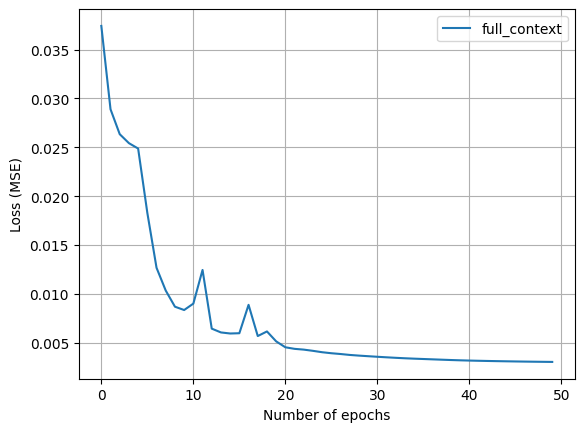

In [88]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), train_loss, color = f"C{0}", label = "full_context")
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

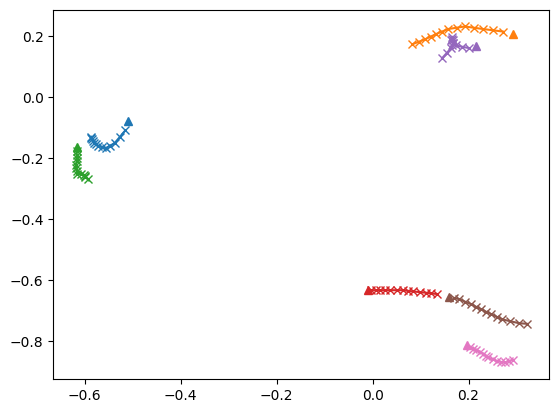

In [71]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])


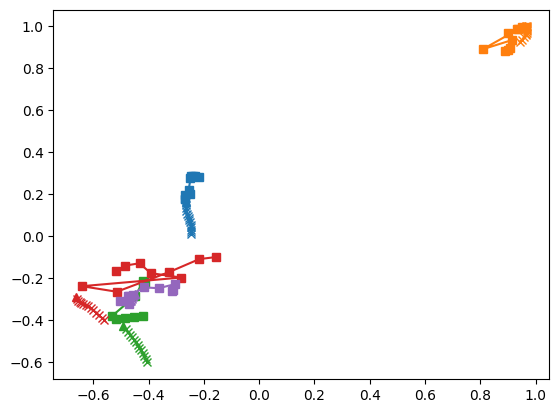

In [78]:
prediction_steps = 10

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)